In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import gzip
import sqlite3
import csv
import numpy as np
import seaborn as sns

In [5]:
df1 = pd.read_csv('data/zippedData/bom.movie_gross.csv.gz')
df1 = df1.rename(columns = {'title':'movie'})

In [6]:
df4 = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
df4 = df4.rename(columns = {'primary_title':'movie'})

In [7]:
df11 = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')
df11['worldwide_gross'] = df11['worldwide_gross'].str[1:]
df11['worldwide_gross'] = df11['worldwide_gross'].str.replace(',', '').astype(np.int64)
df11['domestic_gross'] = df11['domestic_gross'].str[1:]
df11['domestic_gross'] = df11['domestic_gross'].str.replace(',', '').astype(np.int64)
df11['production_budget'] = df11['production_budget'].str[1:]
df11['production_budget'] = df11['production_budget'].str.replace(',', '').astype(np.int64)

production = df11[df11.production_budget < 1000000].index
df11.drop(production, inplace=True)
domestic = df11[df11.domestic_gross < 1].index
df11.drop(domestic, inplace=True)
worldwide = df11[df11.worldwide_gross < 1].index
df11.drop(worldwide, inplace=True)
df11.set_index('movie')

,id,release_date,production_budget,domestic_gross,worldwide_gross
movie,,,,,
Avatar,1,"Dec 18, 2009",425000000,760507625,2776345279
Pirates of the Caribbean: On Stranger Tides,2,"May 20, 2011",410600000,241063875,1045663875
Dark Phoenix,3,"Jun 7, 2019",350000000,42762350,149762350
Avengers: Age of Ultron,4,"May 1, 2015",330600000,459005868,1403013963
Star Wars Ep. VIII: The Last Jedi,5,"Dec 15, 2017",317000000,620181382,1316721747
...,...,...,...,...,...
Sparkler,95,"Mar 19, 1999",1000000,5494,5494
The Helixâ¦Loaded,96,"Mar 18, 2005",1000000,3700,3700
Childless,97,"May 15, 2015",1000000,1036,1036


In [45]:
BigFrame = df11.merge(df1, on='movie').merge(df4, on='movie').drop(columns=['tconst', 'original_title', 'start_year', 'id', 'domestic_gross_y'])

In [46]:
BigFrame = BigFrame.drop_duplicates(subset='movie').set_index('movie')
BigFrame['month'] = BigFrame['release_date'].str[:3]

In [47]:
BigFrame = BigFrame.dropna()
BigFrame.dropna(inplace=True)

In [48]:
# Order month by order in the calender then sort the calenders in order from Jan-Dec

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [50]:
df_2013 = BigFrame[BigFrame['year'] == 2013]
df_2014 = BigFrame[BigFrame['year'] == 2014]
df_2015 = BigFrame[BigFrame['year'] == 2015]
df_2016 = BigFrame[BigFrame['year'] == 2016]
df_2017 = BigFrame[BigFrame['year'] == 2017]
df_2018 = BigFrame[BigFrame['year'] == 2018]

In [51]:
df_2013 = df_2013[['worldwide_gross', 'month']]
df_2013 = df_2013.dropna(subset=['month'])

df_jan2013 = df_2013[df_2013['month'] == 'Jan'].mean().astype(np.int64)
df_feb2013 = df_2013[df_2013['month'] == 'Feb'].mean().astype(np.int64)
df_mar2013 = df_2013[df_2013['month'] == 'Mar'].mean().astype(np.int64)
df_apr2013 = df_2013[df_2013['month'] == 'Apr'].mean().astype(np.int64)
df_may2013 = df_2013[df_2013['month'] == 'May'].mean().astype(np.int64)
df_jun2013 = df_2013[df_2013['month'] == 'Jun'].mean().astype(np.int64)
df_jul2013 = df_2013[df_2013['month'] == 'Jul'].mean().astype(np.int64)
df_aug2013 = df_2013[df_2013['month'] == 'Aug'].mean().astype(np.int64)
df_sep2013 = df_2013[df_2013['month'] == 'Sep'].mean().astype(np.int64)
df_oct2013 = df_2013[df_2013['month'] == 'Oct'].mean().astype(np.int64)
df_nov2013 = df_2013[df_2013['month'] == 'Nov'].mean().astype(np.int64)
df_dec2013 = df_2013[df_2013['month'] == 'Dec'].mean().astype(np.int64)

In [52]:
df_2014 = df_2014[['worldwide_gross', 'month']]
df_2014 = df_2014.dropna(subset=['month'])

df_jan2014 = df_2014[df_2014['month'] == 'Jan'].mean().astype(np.int64)
df_feb2014 = df_2014[df_2014['month'] == 'Feb'].mean().astype(np.int64)
df_mar2014 = df_2014[df_2014['month'] == 'Mar'].mean().astype(np.int64)
df_apr2014 = df_2014[df_2014['month'] == 'Apr'].mean().astype(np.int64)
df_may2014 = df_2014[df_2014['month'] == 'May'].mean().astype(np.int64)
df_jun2014 = df_2014[df_2014['month'] == 'Jun'].mean().astype(np.int64)
df_jul2014 = df_2014[df_2014['month'] == 'Jul'].mean().astype(np.int64)
df_aug2014 = df_2014[df_2014['month'] == 'Aug'].mean().astype(np.int64)
df_sep2014 = df_2014[df_2014['month'] == 'Sep'].mean().astype(np.int64)
df_oct2014 = df_2014[df_2014['month'] == 'Oct'].mean().astype(np.int64)
df_nov2014 = df_2014[df_2014['month'] == 'Nov'].mean().astype(np.int64)
df_dec2014 = df_2014[df_2014['month'] == 'Dec'].mean().astype(np.int64)

In [53]:
df_2015 = df_2015[['worldwide_gross', 'month']]
df_2015 = df_2015.dropna(subset=['month'])

df_jan2015 = df_2015[df_2015['month'] == 'Jan'].mean().astype(np.int64)
df_feb2015 = df_2015[df_2015['month'] == 'Feb'].mean().astype(np.int64)
df_mar2015 = df_2015[df_2015['month'] == 'Mar'].mean().astype(np.int64)
df_apr2015 = df_2015[df_2015['month'] == 'Apr'].mean().astype(np.int64)
df_may2015 = df_2015[df_2015['month'] == 'May'].mean().astype(np.int64)
df_jun2015 = df_2015[df_2015['month'] == 'Jun'].mean().astype(np.int64)
df_jul2015 = df_2015[df_2015['month'] == 'Jul'].mean().astype(np.int64)
df_aug2015 = df_2015[df_2015['month'] == 'Aug'].mean().astype(np.int64)
df_sep2015 = df_2015[df_2015['month'] == 'Sep'].mean().astype(np.int64)
df_oct2015 = df_2015[df_2015['month'] == 'Oct'].mean().astype(np.int64)
df_nov2015 = df_2015[df_2015['month'] == 'Nov'].mean().astype(np.int64)
df_dec2015 = df_2015[df_2015['month'] == 'Dec'].mean().astype(np.int64)

In [54]:
df_2016 = df_2016[['worldwide_gross', 'month']]
df_2016 = df_2016.dropna(subset=['month'])

df_jan2016 = df_2016[df_2016['month'] == 'Jan'].mean().astype(np.int64)
df_feb2016 = df_2016[df_2016['month'] == 'Feb'].mean().astype(np.int64)
df_mar2016 = df_2016[df_2016['month'] == 'Mar'].mean().astype(np.int64)
df_apr2016 = df_2016[df_2016['month'] == 'Apr'].mean().astype(np.int64)
df_may2016 = df_2016[df_2016['month'] == 'May'].mean().astype(np.int64)
df_jun2016 = df_2016[df_2016['month'] == 'Jun'].mean().astype(np.int64)
df_jul2016 = df_2016[df_2016['month'] == 'Jul'].mean().astype(np.int64)
df_aug2016 = df_2016[df_2016['month'] == 'Aug'].mean().astype(np.int64)
df_sep2016 = df_2016[df_2016['month'] == 'Sep'].mean().astype(np.int64)
df_oct2016 = df_2016[df_2016['month'] == 'Oct'].mean().astype(np.int64)
df_nov2016 = df_2016[df_2016['month'] == 'Nov'].mean().astype(np.int64)
df_dec2016 = df_2016[df_2016['month'] == 'Dec'].mean().astype(np.int64)

In [55]:
df_2017 = df_2017[['worldwide_gross', 'month']]
df_2017 = df_2017.dropna(subset=['month'])

df_jan2017 = df_2017[df_2017['month'] == 'Jan'].mean().astype(np.int64)
df_feb2017 = df_2017[df_2017['month'] == 'Feb'].mean().astype(np.int64)
df_mar2017 = df_2017[df_2017['month'] == 'Mar'].mean().astype(np.int64)
df_apr2017 = df_2017[df_2017['month'] == 'Apr'].mean().astype(np.int64)
df_may2017 = df_2017[df_2017['month'] == 'May'].mean().astype(np.int64)
df_jun2017 = df_2017[df_2017['month'] == 'Jun'].mean().astype(np.int64)
df_jul2017 = df_2017[df_2017['month'] == 'Jul'].mean().astype(np.int64)
df_aug2017 = df_2017[df_2017['month'] == 'Aug'].mean().astype(np.int64)
df_sep2017 = df_2017[df_2017['month'] == 'Sep'].mean().astype(np.int64)
df_oct2017 = df_2017[df_2017['month'] == 'Oct'].mean().astype(np.int64)
df_nov2017 = df_2017[df_2017['month'] == 'Nov'].mean().astype(np.int64)
df_dec2017 = df_2017[df_2017['month'] == 'Dec'].mean().astype(np.int64)

In [56]:
df_2018 = df_2018[['worldwide_gross', 'month']]
df_2018 = df_2018.dropna(subset=['month'])

df_jan2018 = df_2018[df_2018['month'] == 'Jan'].mean().astype(np.int64)
df_feb2018 = df_2018[df_2018['month'] == 'Feb'].mean().astype(np.int64)
df_mar2018 = df_2018[df_2018['month'] == 'Mar'].mean().astype(np.int64)
df_apr2018 = df_2018[df_2018['month'] == 'Apr'].mean().astype(np.int64)
df_may2018 = df_2018[df_2018['month'] == 'May'].mean().astype(np.int64)
df_jun2018 = df_2018[df_2018['month'] == 'Jun'].mean().astype(np.int64)
df_jul2018 = df_2018[df_2018['month'] == 'Jul'].mean().astype(np.int64)
df_aug2018 = df_2018[df_2018['month'] == 'Aug'].mean().astype(np.int64)
df_sep2018 = df_2018[df_2018['month'] == 'Sep'].mean().astype(np.int64)
df_oct2018 = df_2018[df_2018['month'] == 'Oct'].mean().astype(np.int64)
df_nov2018 = df_2018[df_2018['month'] == 'Nov'].mean().astype(np.int64)
df_dec2018 = df_2018[df_2018['month'] == 'Dec'].mean().astype(np.int64)

In [57]:
mean_2013 = [df_jan2013[0], df_feb2013[0], df_mar2013[0], df_apr2013[0], df_may2013[0], df_jun2013[0],\
             df_jul2013[0], df_aug2013[0], df_sep2013[0], df_oct2013[0], df_nov2013[0], df_dec2013[0]]
mean_2014 = [df_jan2014[0], df_feb2014[0], df_mar2014[0], df_apr2014[0], df_may2014[0], df_jun2014[0],\
             df_jul2014[0], df_aug2014[0], df_sep2014[0], df_oct2014[0], df_nov2014[0], df_dec2014[0]]
mean_2015 = [df_jan2015[0], df_feb2015[0], df_mar2015[0], df_apr2015[0], df_may2015[0], df_jun2015[0],\
             df_jul2015[0], df_aug2015[0], df_sep2015[0], df_oct2015[0], df_nov2015[0], df_dec2015[0]]
mean_2016 = [df_jan2016[0], df_feb2016[0], df_mar2016[0], df_apr2016[0], df_may2016[0], df_jun2016[0],\
             df_jul2016[0], df_aug2016[0], df_sep2016[0], df_oct2016[0], df_nov2016[0], df_dec2016[0]]
mean_2017 = [df_jan2017[0], df_feb2017[0], df_mar2017[0], df_apr2017[0], df_may2017[0], df_jun2017[0],\
             df_jul2017[0], df_aug2017[0], df_sep2017[0], df_oct2017[0], df_nov2017[0], df_dec2017[0]]
mean_2018 = [df_jan2018[0], df_feb2018[0], df_mar2018[0], df_apr2018[0], df_may2018[0], df_jun2018[0],\
             df_jul2018[0], df_aug2018[0], df_sep2018[0], df_oct2018[0], df_nov2018[0], df_dec2018[0]]

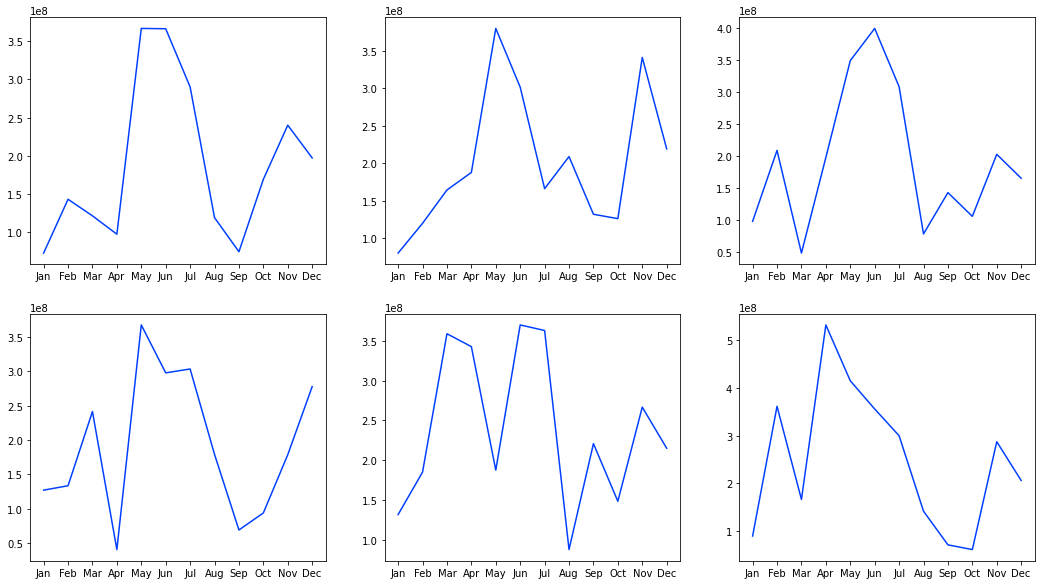

In [58]:
plt.style.use('seaborn-bright')
fig, ax = plt.subplots(2, 3, figsize = (18, 10))
x = column_names
ax[0,0].plot(x, mean_2013)
ax[0,1].plot(x, mean_2014)
ax[0,2].plot(x, mean_2015)
ax[1,0].plot(x, mean_2016)
ax[1,1].plot(x, mean_2017)
ax[1,2].plot(x, mean_2018)
#sns.barplot(x, y);

In [59]:
df_complete = BigFrame[['production_budget','worldwide_gross', 'year', 'month']]

column_names = months
a = np.zeros(shape=(1,12), dtype = int)
df_months = pd.DataFrame(a, columns = column_names)

for x in df_complete:
    if x in column_names:
        df_months[x] += 1

In [60]:
# Get the values from this function and copy them below *here*

list(df_months.value_counts().index)

[(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)]

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


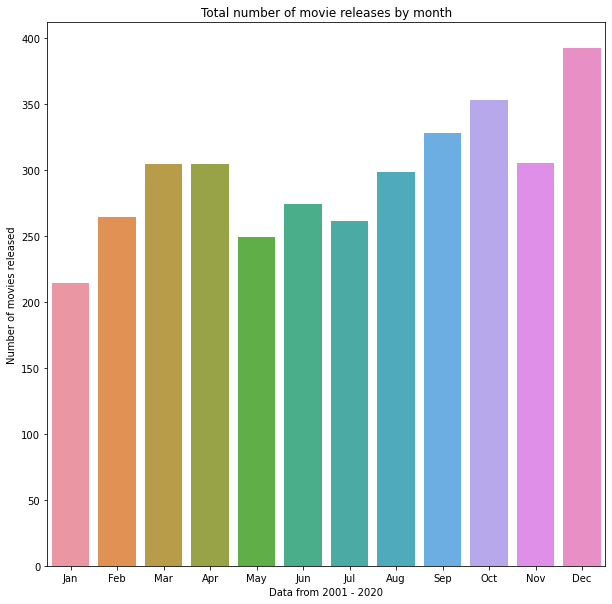

In [61]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-bright')
fig, ax = plt.subplots(figsize = (10, 10))
x = months
#y = [*here*]
y = [214, 264, 304, 304, 249, 274, 261, 298, 328, 353, 305, 392]
sns.barplot(x, y);
ax.set_title('Total number of movie releases by month')
ax.set_xlabel('Data from 2001 - 2020')
ax.set_ylabel('Number of movies released');

In [62]:
# The best window to release our blockbuster action / drama/ suspense film is releasing during the holiday season.
# This distribution shows that other big name movie production companies release later in the year.